# **1. IMPORTING LIBRARIES**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import SeparableConv2D, ZeroPadding2D, Conv2D, MaxPool2D, BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

In [3]:
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix

# **2. EDA**

In [4]:
inputdir = '../input/chest-xray-pneumonia/chest_xray'
path_train = inputdir + '/train'
path_test = inputdir + '/test'
path_val = inputdir + '/val'
train_normal = os.path.join(path_train + '/NORMAL')
train_pneumonia = os.path.join(path_train + '/PNEUMONIA')
test_normal = os.path.join(path_test + '/NORMAL')
test_pneumonia = os.path.join(path_test + '/PNEUMONIA')
val_normal = os.path.join(path_val + '/NORMAL')
val_pneumonia = os.path.join(path_val + '/PNEUMONIA')
print("Total number of normal images in training set: ",len(os.listdir(train_normal)))
print("Total number of pneumonic images in training set: ",len(os.listdir(train_pneumonia)))
print("Total number of normal images in test set: ",len(os.listdir(test_normal)))
print("Total number of pneumonic images in test set: ",len(os.listdir(test_pneumonia)))
print("Total number of normal images in val set: ", len(os.listdir(val_normal)))
print("Total number of pnuemonic images in val set: ", len(os.listdir(val_pneumonia)))

Total number of normal images in training set:  1341
Total number of pneumonic images in training set:  3875
Total number of normal images in test set:  234
Total number of pneumonic images in test set:  390
Total number of normal images in val set:  8
Total number of pnuemonic images in val set:  8


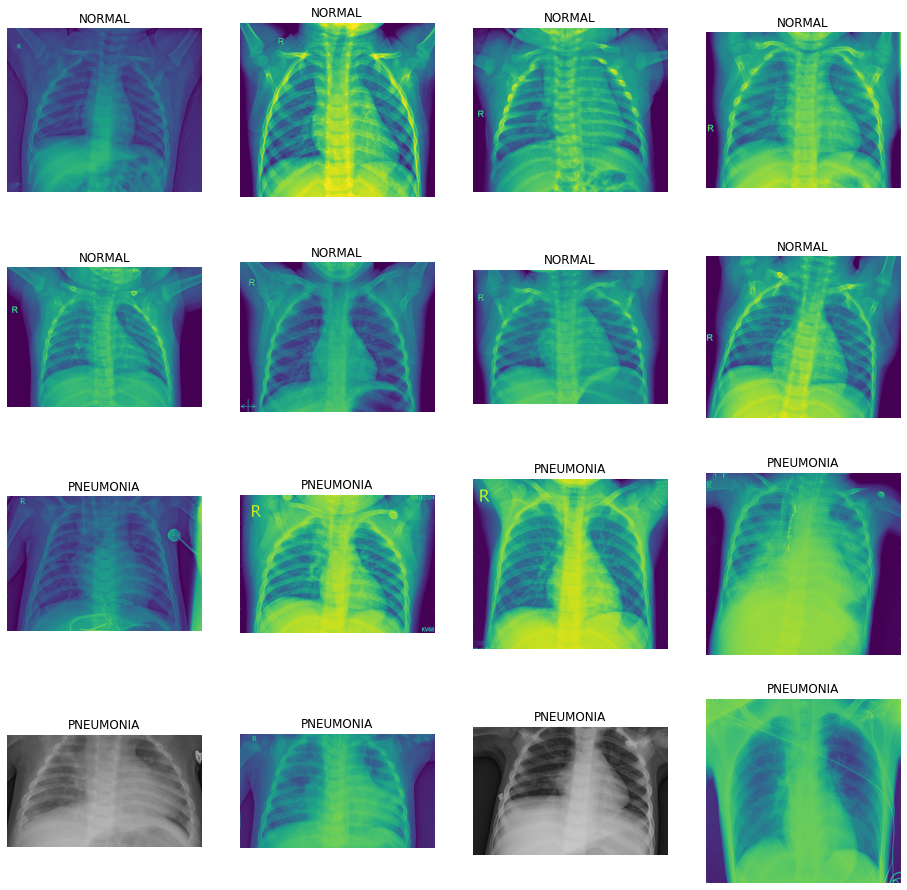

In [5]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
next_normal_pix = [os.path.join(train_normal, fname) for fname in os.listdir(train_normal)[0:8]]
next_pneumonia_pix = [os.path.join(train_pneumonia, fname) for fname in os.listdir(train_pneumonia)[0:8]]
for i, img_path in enumerate(next_normal_pix+next_pneumonia_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(img_path)
    if i<=7 :
        sp.title.set_text('NORMAL')
    else :
        sp.title.set_text('PNEUMONIA')
    plt.imshow(img)
plt.show()

# **3. DATA PREPROCESSING**

In [6]:
def data_processing(img_size, batch_size):
    
    train_datagen = ImageDataGenerator(rescale = 1./255, 
                                       zoom_range = 0.3, 
                                       vertical_flip = True, 
                                       width_shift_range = 0.1, 
                                       height_shift_range = 0.1)
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    train_set = train_datagen.flow_from_directory(
        path_train, 
        target_size=(img_size, img_size), 
        batch_size=batch_size, 
        class_mode='binary', 
        shuffle=True)
    
    val_set = val_datagen.flow_from_directory(
        path_val, 
        target_size=(img_size, img_size), 
        batch_size=batch_size, 
        class_mode='binary', 
        shuffle=True)

    test_data = []
    test_labels = []
    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(path_test + cond)):
            img = plt.imread(path_test + cond + img)
            img = cv2.resize(img, (img_size, img_size))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond == '/NORMAL/':
                label = 0
            elif cond == '/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_set, val_set, test_data, test_labels

In [7]:
img_size = 150
batch_size = 32
train_set, val_set, test_data, test_labels = data_processing(img_size, batch_size)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


# **4. BUILDING THE MODEL**

In [8]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), input_shape = train_set.image_shape, activation = 'relu', padding = 'same'))
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(SeparableConv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(SeparableConv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(SeparableConv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.2))

model.add(SeparableConv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.2))


model.add(Flatten())
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(rate = 0.7))
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(rate = 0.3))

model.add(Dense(units = 1, activation = 'sigmoid'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 75, 75, 32)        688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 75, 75, 32)        1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0

# **5. COMPILING THE MODEL AND CALLBACKS**

In [11]:
model.compile(optimizer = Adam(lr = 0.001, decay = 1e-5), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [12]:
checkpoint = ModelCheckpoint(filepath = 'trained_pneumonia_model.h5', save_best_only = True, save_weights_only = False)
lr_reduce = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, patience = 2, verbose = 2, mode = 'max')

# **6. TRAINING THE MODEL**

In [13]:
model_training = model.fit_generator(train_set, 
                              steps_per_epoch = train_set.samples // batch_size, 
                              epochs = 12, 
                              validation_data = val_set,  
                              callbacks = [checkpoint, lr_reduce])

Epoch 1/12
163/163 [==============================] - 113s 693ms/step - loss: 0.3757 - accuracy: 0.8163 - val_loss: 0.9524 - val_accuracy: 0.5000
Epoch 2/12
163/163 [==============================] - 87s 532ms/step - loss: 0.3006 - accuracy: 0.8685 - val_loss: 1.2817 - val_accuracy: 0.5000
Epoch 3/12
163/163 [==============================] - 86s 530ms/step - loss: 0.2966 - accuracy: 0.8740 - val_loss: 1.0679 - val_accuracy: 0.5000
Epoch 4/12
163/163 [==============================] - ETA: 0s - loss: 0.2654 - accuracy: 0.8915
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 87s 536ms/step - loss: 0.2654 - accuracy: 0.8915 - val_loss: 0.7202 - val_accuracy: 0.6250
Epoch 5/12
163/163 [==============================] - 87s 535ms/step - loss: 0.2381 - accuracy: 0.9074 - val_loss: 0.9446 - val_accuracy: 0.5625
Epoch 6/12
163/163 [==============================] - 86s 527ms/step - loss: 0.2168 - accuracy: 0.9101 - val_

# **7. MODEL EVALUATION**

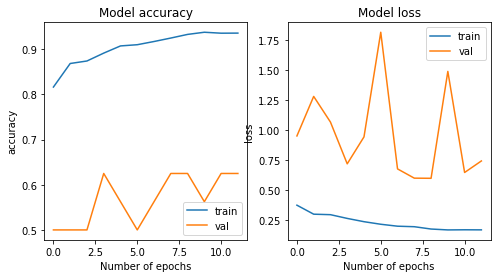

In [14]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4))
ax = ax.ravel()

for i, metric in enumerate(['accuracy', 'loss']):
    ax[i].plot(model_training.history[metric])
    ax[i].plot(model_training.history['val_' + metric])
    ax[i].set_title('Model {}'.format(metric))
    ax[i].set_xlabel('Number of epochs')
    ax[i].set_ylabel(metric)
    ax[i].legend(['train', 'val'])

Text(0.5, 1.0, 'Confusion Matrix')

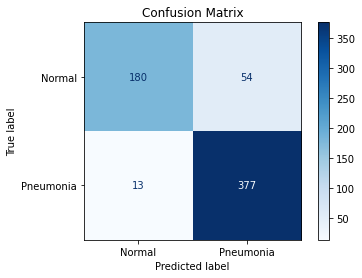

In [15]:
predictions = model.predict(test_data)
accuracy = accuracy_score(test_labels, np.round(predictions))*100
cm = confusion_matrix(test_labels, np.round(predictions))

cmd = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Pneumonia'])
cmd.plot(cmap = plt.cm.Blues)
plt.title('Confusion Matrix')

In [17]:
tn, fp, fn, tp = cm.ravel()
print('Test Metrics:')
precision = tp / (tp + fp) * 100
recall = tp / (tp + fn) * 100
print('Accuracy: {}%'.format(accuracy))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

Test Metrics:
Accuracy: 89.26282051282051%
Precision: 87.47099767981439%
Recall: 96.66666666666667%
F1-score: 91.83922046285018


In [26]:
from sklearn.metrics import classification_report

predictions = np.round(model.predict(test_data))
print(classification_report(test_labels, predictions, target_names = ['Normal (Class 0)','Pnuemonia (Class 1)']))

                     precision    recall  f1-score   support

   Normal (Class 0)       0.93      0.77      0.84       234
Pnuemonia (Class 1)       0.87      0.97      0.92       390

           accuracy                           0.89       624
          macro avg       0.90      0.87      0.88       624
       weighted avg       0.90      0.89      0.89       624

